# The Capacitated Vehicle Routing Problem

Using **Iterated Local Search** 

In [27]:
import numpy as np
import pandas as pd
from numpy.random import RandomState
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from metapy.tsp.euclidean import gen_matrix, euclidean_distance
from metapy.local_search.two_opt import OrdinaryDecentTwoOpt
from metapy.local_search.random_restarts import (IteratedLocalSearch, 
                                                 EpsilonGreedyHomeBase)
from metapy.tsp.objective import CVRPUnitDemandObjective

from joblib import Parallel, delayed

In [28]:
def multiple_runs(n_patients, random_states, ils_iter, instance_seed=101, n_jobs=-1):
    x_coords, y_coords = generate_instance(n_patients, random_state=instance_seed)
    
    coords = [[x, y] for x, y in zip(x_coords, y_coords)]
    matrix = gen_matrix(np.array(coords))
    
    
    res = Parallel(n_jobs=n_jobs)(delayed(single_run)(n_patients, matrix, rs, 
                   ils_iter) for rs in random_states)
    
    return res

def single_run(n_patients, distance_matrix, random_state, ils_iter=20):
    init_solution = np.arange(n_patients+1)
    ils_solver = create_solver(distance_matrix, 4, init_solution, random_state=random_state)
    ils_solver.run(n=ils_iter)
    return ils_solver.get_best_solutions()[0]

In [29]:
def plot_solution(routes, x_coords, y_coords):
    
    xc = x_coords
    yc = y_coords
    
    for route in routes:
        
        for k in range(len(route)-1):
            i, j = route[k], route[k+1]
            plt.plot([xc[i], xc[j]], [yc[i], yc[j]], c='green')
            
        plt.plot([xc[route[-1]], xc[0]], [yc[route[-1]], yc[0]], c='green')
        plt.plot([xc[route[0]], xc[0]], [yc[route[0]], yc[0]], c='green')
    
    plt.plot(xc[0], yc[0], c='r', marker='^')
    plt.scatter(xc[1:], yc[1:], c='b')
    
    i = 1
    for x, y in zip(x_coords[1:], y_coords[1:]):
        #plt.text(x * (1 + 0.01), y * (1 + 0.01) , i, fontsize=12)
        i += 1
        

In [30]:
def generate_instance(n_patients, random_state=None):

    #random number generator for synthetic data.
    rand_gen = RandomState(seed=random_state)

    #n_patients = 1 so we include the depot
    x_coords = rand_gen.random(size=n_patients+1) * 200
    y_coords = rand_gen.random(size=n_patients+1) * 100

    return x_coords, y_coords

In [31]:
def plot_patient_coordinates(x_coords, y_coords):
    '''
    Plot a simple scatter of coordinates. 
    Depot is red, customers are blue
    
    Paramters:
    x_coords: array-like
        x coordinates for each patient. element 0 = depot.
        
    y_coords: array-like
        y coordinates for each patient. element 0 = depot
    '''
    plt.plot(x_coords[0], y_coords[0], c='r', marker='^')
    
    for i in range(1, len(x_coords[1:])):
        x = x_coords[i]
        y = y_coords[i]
        plt.plot(x, y, 'b*')
        plt.text(x * (1 + 0.01), y * (1 + 0.01) , i, fontsize=12)
    
    plt.xlim((0, 220))
    plt.ylim((0, 120))
    plt.show()

In [32]:
def convert_tour_to_routes(tour, capacity):
    '''
    Easy as demand comes in single units and
    capacity is an integer
    '''
    n_cities = len(tour)
    capacity = int(capacity)
    splits = [i for i in range(capacity, n_cities, capacity)]
    routes = np.split(tour, splits)
    return routes

In [33]:
def create_solver(matrix, capacity, init_solution, random_state=None):
    '''
    create an istance of a ILS solver
    '''
    cvrp_obj = CVRPUnitDemandObjective(matrix, 0, capacity)
    local_search = OrdinaryDecentTwoOpt(cvrp_obj, init_solution)
    ils = IteratedLocalSearch(cvrp_obj, 
                              local_search, 
                              accept=EpsilonGreedyHomeBase(), 
                              maximisation=False,
                              random_state=random_state)
    return ils

In [34]:
def load_and_plot_solution(filename):
    active_arcs = pd.read_csv(filename).to_numpy()
    x_coords, y_coords = active_arcs
    xc = x_coords
    yc = y_coords

    for i, j in active_arcs:
        plt.plot([xc[i], xc[j]], [yc[i], yc[j]], c='green')
        plt.plot(xc[0], yc[0], c='r', marker='^')
        plt.scatter(xc[1:], yc[1:], c='b')
        
    plt.show()

In [35]:
def comparison_plot(routes, x_coords, y_coords, comparison_file_name,
                    label_1 = 'ILS', label_2='Gurobi'):
    xc = x_coords
    yc = y_coords
    
    fig, ax = plt.subplots(1, 2, figsize=(12,4), sharey=True)
    
    for route in routes:
        
        for k in range(len(route)-1):
            i, j = route[k], route[k+1]
            ax[0].plot([xc[i], xc[j]], [yc[i], yc[j]], c='green')
            
        ax[0].plot([xc[route[-1]], xc[0]], [yc[route[-1]], yc[0]], c='green')
        ax[0].plot([xc[route[0]], xc[0]], [yc[route[0]], yc[0]], c='green')
    
    ax[0].plot(xc[0], yc[0], c='r', marker='^')
    ax[0].scatter(xc[1:], yc[1:], c='b')
    ax[0].set_title(label_1)
    
    active_arcs = pd.read_csv(comparison_file_name).to_numpy()

    for i, j in active_arcs:
        ax[1].plot([xc[i], xc[j]], [yc[i], yc[j]], c='green')
        ax[1].plot(xc[0], yc[0], c='r', marker='^')
        ax[1].scatter(xc[1:], yc[1:], c='b')
    ax[1].set_title(label_2)

    

## Parameters

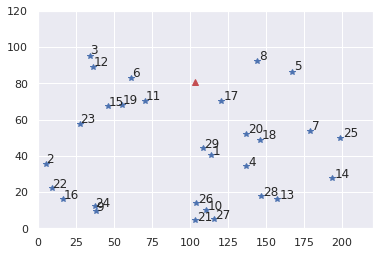

In [36]:
N_PATIENTS = 30
SEED = 101

#visualise
x_coords, y_coords = generate_instance(N_PATIENTS, random_state=SEED)
plot_patient_coordinates(x_coords, y_coords)

## Solution using Iterated Local Search

In [37]:
%%time 
N_PATIENTS = 30
INSTANCE_SEED = 101
ILS_ITERS = 20 

#create patient data, distance between patients and initial solution.
x_coords, y_coords = generate_instance(N_PATIENTS, random_state=INSTANCE_SEED)
coords = [[x, y] for x, y in zip(x_coords, y_coords)]
init_solution = np.arange(N_PATIENTS+1)
distance_matrix = gen_matrix(np.array(coords))

#use ILS to generate a 'good' solution.
ils_solver = create_solver(distance_matrix, 4, init_solution, random_state=28)
ils_solver.run(n=ILS_ITERS)

print(f'ILS solution: {ils_solver.get_best_solutions()[0]:.2f}')

ILS solution: 1452.55
CPU times: user 4.79 s, sys: 1.65 ms, total: 4.79 s
Wall time: 4.79 s


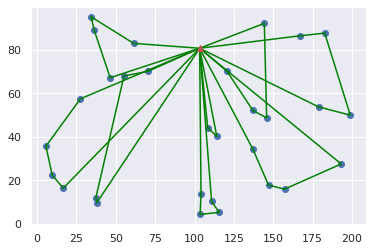

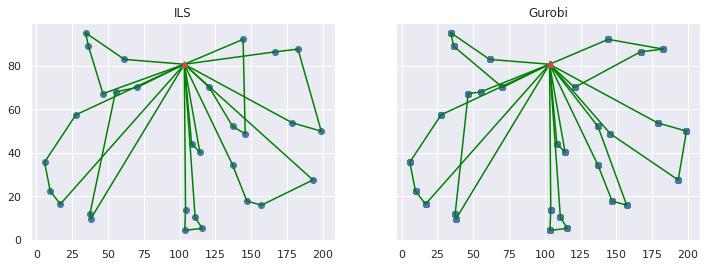

In [38]:
import csv
solution = ils_solver.get_best_solutions()[1][0]
routes = convert_tour_to_routes(solution[1:], 4)

with open('arco.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(routes)


plot_solution(routes, x_coords, y_coords)
comparison_plot(routes, x_coords, y_coords, 'best_solution_30_patients.csv')